## Downloading the jp2 file section

In [1]:
import gdown

url  = "https://drive.google.com/file/d/1Hb7Lgo5vtbAtr36fq6knylSiATlJRDS6/view?usp=share_link"
output = "./storage/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2"


model_url = "https://drive.google.com/file/d/1SbSArI3KOOWHxRlxnjchO7_MbWzB4lNR/view"
model_output = "hovernet_fast_pannuke_type_tf2pytorch.tar"


storage_dir = "./storage"

In [2]:
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1Hb7Lgo5vtbAtr36fq6knylSiATlJRDS6
To: /workspace/Benchmark/storage/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2
100%|██████████████████████████████████████████████████████████████████████████████| 13.0G/13.0G [03:38<00:00, 59.6MB/s]


'./storage/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2'

## Model checkpoint

In [39]:
gdown.download(url=model_url, output=model_output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1SbSArI3KOOWHxRlxnjchO7_MbWzB4lNR
To: /workspace/Benchmark/hovernet_fast_pannuke_type_tf2pytorch.tar
100%|████████████████████████████████████████████████████████████████████████████████| 151M/151M [00:10<00:00, 14.1MB/s]


'hovernet_fast_pannuke_type_tf2pytorch.tar'

In [1]:
!ls

TensorRT				   models
Untitled.ipynb				   onnx_export
hovernet_fast_monusac_type_tf2pytorch.tar  run_utils
hovernet_fast_pannuke_type_tf2pytorch.tar  storage
jp2tileaccesor


## Importing the neccesary libs to access the jp2 file

In [2]:
from jp2tileaccesor.multi_res_Tiling import SectionProxy, TileAccessor, Span

In [3]:
proxy_lossless = SectionProxy(15, "NISSL", 1708)

print(proxy_lossless)

{'id': 5944, 'position_index': 1708, 'jp2Path': '/data/storageIIT/humanbrain/analytics/37/NISL/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2', 'pngPathLow': '/data/storageIIT/humanbrain/analytics/37/NISL/B_37_FB3-SL_570-ST_NISL-SE_1708_thumbnail.jpg', 'width': 81590, 'height': 83590, 'series': 10, 'rigidrotation': 90, 'notes': None}{'brainid': 15, 'seriesType': 'NISSL', 'secnumber': 1708, 'modes': {'jp2': False, 'iip': True, 'mmap': False, 'tif': False}}


In [4]:
proxy_lossless.check_local_jp2()

./storage/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2


True

In [5]:
Image_size = 256
size = Span(Image_size,Image_size)
accessor = TileAccessor(proxy_lossless, 0, tilespan = size, use_iip = False)
print(accessor)

{'proxy': "{'id': 5944, 'position_index': 1708, 'jp2Path': '/data/storageIIT/humanbrain/analytics/37/NISL/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2', 'pngPathLow': '/data/storageIIT/humanbrain/analytics/37/NISL/B_37_FB3-SL_570-ST_NISL-SE_1708_thumbnail.jpg', 'width': 81590, 'height': 83590, 'series': 10, 'rigidrotation': 90, 'notes': None}{'brainid': 15, 'seriesType': 'NISSL', 'secnumber': 1708, 'modes': {'jp2': True, 'iip': True, 'mmap': False, 'tif': False}}", 'resolution': 0, 'imagespan': Span(w=81590, h=83590), 'tilespan': Span(w=256, h=256), 'ntiles': 104313, 'ntiles_c': 319, 'ntiles_r': 327}


In [6]:
import os
from PIL import Image
import numpy as np
import tensorrt
import onnx
import gc
import models.hovernet.net_desc as net
import torch
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


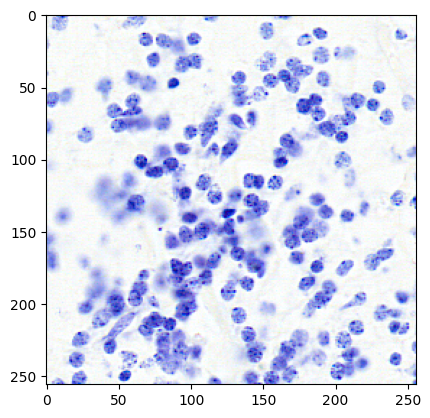

In [9]:
tile = accessor[np.random.randint(accessor.ntiles)]
plt.imshow(tile[0])

In [8]:
accessor[np.random.randint(accessor.ntiles)][0].shape

(256, 256, 3)

* Randomly sampling the images to make a dataset to test all models on.
* Tiles are selected at random because continous selection can lead to rows of tiles which do not contain brain matter.

In [10]:
# num_tiles = 1024
# t=0
# if not os.path.exists(storage_dir + "/cache_" + str(Image_size)):
#     os.makedirs(storage_dir + "/cache_" + str(Image_size))

# for i in range(0,accessor.ntiles):
#     if t >= num_tiles:
#         break
#     tile = accessor[np.random.randint(accessor.ntiles)]
#     if tile[0].shape == (256, 256, 3):
#         plt.imsave(storage_dir+"/cache_"+str(Image_size) + "/"+str(i)+".png",tile[0])
#         t+=1

In [10]:
file_list = os.listdir(storage_dir+"/cache_"+str(Image_size))
print("Number of Images",len(file_list))
pics = [ storage_dir + "/cache_"+str(Image_size) + "/" +str(i) for i in file_list]

Number of Images 1024


In [11]:
np_pics = np.asarray(Image.open(pics[0]))
brain_tiles = np_pics.reshape(1,4,Image_size,Image_size)
for i in range(len(file_list)-1):
    brain_tiles = np.concatenate((brain_tiles,np.asarray(Image.open(pics[i+1])).reshape(1,4,Image_size,Image_size)),axis=0)
    

In [12]:
brain_tiles = torch.from_numpy(brain_tiles).float()

In [13]:
brain_tiles = brain_tiles[:,:3,:,:]

In [14]:
brain_tiles.shape

torch.Size([1024, 3, 256, 256])

## Importing the original Hovernet model

In [15]:
from run_utils.utils import convert_pytorch_checkpoint
model_path = 'hovernet_fast_pannuke_type_tf2pytorch.tar'
hovernet = net.HoVerNet(nr_types = 6,mode='fast')
saved_state_dict = torch.load(model_path)["desc"]
saved_state_dict = convert_pytorch_checkpoint(saved_state_dict)

hovernet.load_state_dict(saved_state_dict, strict=True)
hovernet = torch.nn.DataParallel(hovernet)
hovernet = hovernet.to("cuda")
hovernet.eval()

DataParallel(
  (module): HoVerNet(
    (conv0): Sequential(
      (pad): TFSamepaddingLayer()
      (/): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (d0): ResidualBlock(
      (units): ModuleList(
        (0): Sequential(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (conv1/bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1/relu): ReLU(inplace=True)
          (conv2/pad): TFSamepaddingLayer()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (conv2/bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2/relu): ReLU(inplace=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): Sequential(
          (p

## Timing the model

* model.forward is executed on a given batch size for a given dataset size and during the run gpu resources are monitored and the timing of each call is averaged over 3 calls done with the same images.

In [17]:
%%capture
import numpy as np
import nvidia_smi
nvidia_smi.nvmlInit()
results_run = {}
results_time_in = {}
results_time_out = {}
results_time_load = {}
results_time_gpu = {}
Batch_sizes = [1,2,4,8,16]

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
brain_tiles_cuda = brain_tiles.to('cuda')
for j in Batch_sizes:
    res = []
    res2 = []
    res3 = []
    res4 = []
    res_gpu = []
    res_mem = []
    res_pwr = []
    batch_size = j
    for i in range(0,brain_tiles_cuda.shape[0],batch_size):
        temp = %timeit -n1 -r3 -o hovernet.forward(brain_tiles_cuda[i:i+batch_size,:,:,:])
        res.append(temp)
        g = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
        p = nvidia_smi.nvmlDeviceGetPowerUsage(handle)
        res_gpu.append(g.gpu)
        res_mem.append(g.memory)
        res_pwr.append(p/1000)
        torch.cuda.empty_cache()
        gc.collect()

    a=0
    b=0
    w=0
    for i in res:
        a+=i.average
        b+=i.best
        w+=i.worst
    results_run[j] = (a,b,w)
    results_time_load[j] = (a,b,w)
    results_time_gpu[j] = (res_gpu,res_mem,res_pwr)

In [18]:
results_run

{1: (16.81729539375134, 15.568873578682542, 19.265405280981213),
 2: (15.362417243110636, 7.802729486953467, 27.351385546382517),
 4: (14.192251522094004, 6.475977779831737, 24.292228589765728),
 8: (15.545893542934207, 9.740044672042131, 25.53783655166626),
 16: (15.003927001419166, 7.381142422091216, 23.14212609268725)}

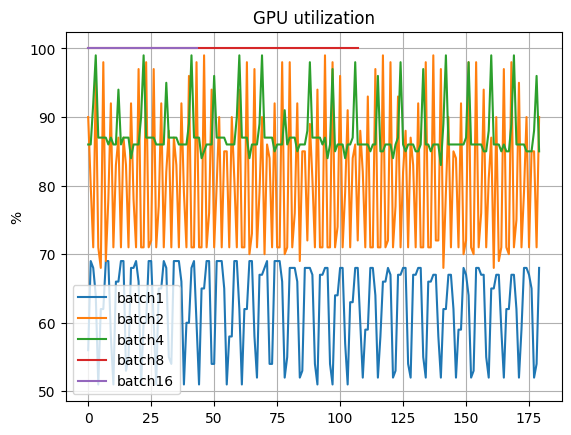

In [19]:
plt.title("GPU utilization")
plt.ylabel("%")
for i in Batch_sizes:
    plt.plot(results_time_gpu[i][0][20:200],label = "batch" + str(i))
    plt.legend()
    
plt.grid()
plt.show()

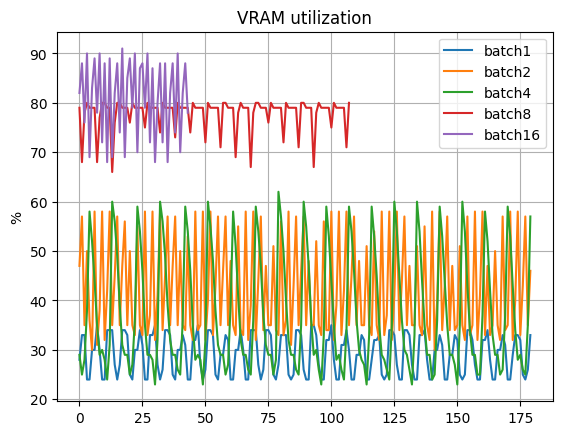

In [20]:
plt.title("VRAM utilization")
plt.ylabel("%")
for i in Batch_sizes:
    plt.plot(results_time_gpu[i][1][20:200],label = "batch" + str(i))
    plt.legend()
    
plt.grid()
plt.show()

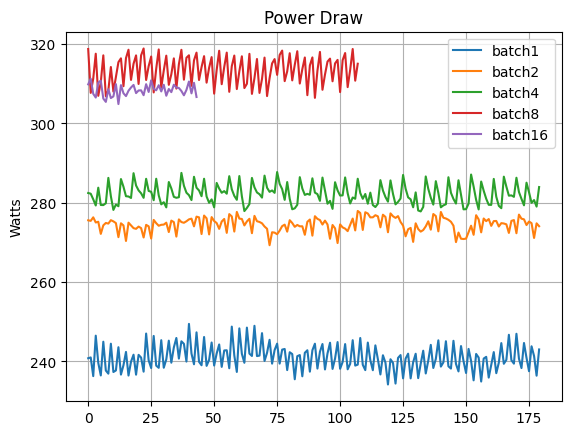

In [23]:
plt.title("Power Draw")
plt.ylabel("Watts")
for i in Batch_sizes:
    plt.plot(results_time_gpu[i][2][20:200],label = "batch" + str(i))
    plt.legend()
    
plt.grid()
plt.show()

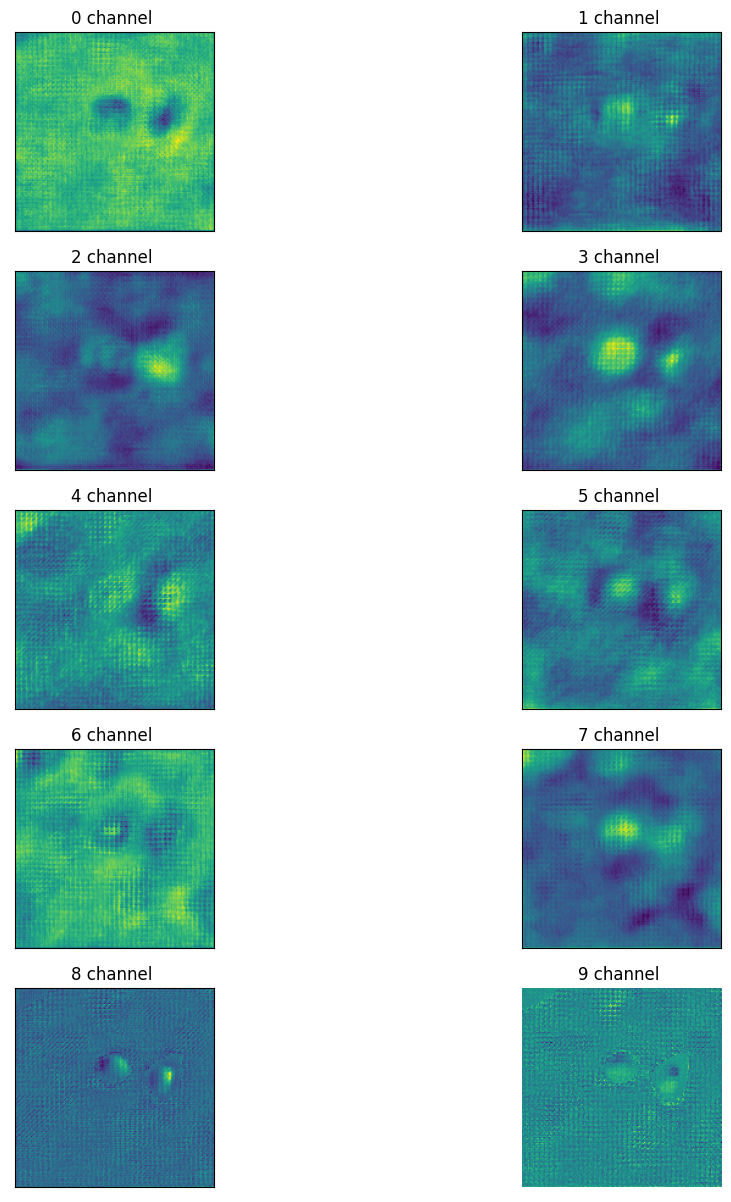

In [15]:
i=500
out = hovernet.forward(brain_tiles[i:i+1,:,:,:])
out = out.cpu()
import matplotlib.pyplot as plt
fig , axs = plt.subplots(5,2,figsize=(12,15))
k=0
plt.axis('off')
count = 0
for i in range(5):
    for j in range(2):
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        axs[i,j].imshow(out[0,k,:,:].detach().numpy())
        axs[i,j].title.set_text( str(k) + " channel ")
        k+=1

## Exporting the model to onnx Format using pytorch onnx export

In [21]:
size = 256
batch = 16

In [22]:
dummy_input = torch.rand(batch,3,size,size)
onnx_name = "./onnx_export/hovernet_" + str(size) + "_" + str(batch) + ".onnx"
dummy_input = dummy_input.to('cuda')

In [23]:
dummy_input.dtype

torch.float32

In [26]:
torch.onnx.export(hovernet.module,dummy_input,onnx_name,export_params=True)

torch.cuda.empty_cache()
gc.collect()

/workspace/Benchmark/models/hovernet/net_utils.py:53: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[2] % self.stride == 0:
/workspace/Inference_rt/models/hovernet/utils.py:40: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert (
/usr/local/lib/python3.8/dist-packages/torch/onnx/_internal/jit_utils.py:257: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_p

8

## Exporting model to plan file to load in TensorRT

In [33]:
!trtexec --onnx="./onnx_export/hovernet_256_16.onnx" --saveEngine="hovernet_256_16_fp16.plan" --buildOnly --fp16 --precisionConstraints=prefer

&&&& RUNNING TensorRT.trtexec [TensorRT v8501] # trtexec --onnx=./onnx_export/hovernet_256_16.onnx --saveEngine=hovernet_256_16_fp16.plan --buildOnly --fp16 --precisionConstraints=prefer
[01/09/2023-00:19:29] [W] When --precisionConstraints flag is set to "obey" or "prefer", please add --layerPrecision/--layerOutputTypes flags to set layer-wise precisions and output types.
[01/09/2023-00:19:29] [I] === Model Options ===
[01/09/2023-00:19:29] [I] Format: ONNX
[01/09/2023-00:19:29] [I] Model: ./onnx_export/hovernet_256_16.onnx
[01/09/2023-00:19:29] [I] Output:
[01/09/2023-00:19:29] [I] === Build Options ===
[01/09/2023-00:19:29] [I] Max batch: explicit batch
[01/09/2023-00:19:29] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[01/09/2023-00:19:29] [I] minTiming: 1
[01/09/2023-00:19:29] [I] avgTiming: 8
[01/09/2023-00:19:29] [I] Precision: FP32+FP16 (prefer precision constraints)
[01/09/2023-00:19:29] [I] LayerPrecisions: 
[01/09/2023

## Running model in TensorRT

In [42]:
import TensorRT.inference as inf
import tensorrt as trt

In [43]:
TRT_LOGGER = trt.Logger(min_severity =trt.ILogger.INTERNAL_ERROR)
def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())


In [44]:
engine_files = {16 : ["hovernet_256_16_TF32.plan","hovernet_256_16_best.plan","hovernet_256_16_fp16.plan"], 8 : ["hovernet_256_8_TF32.plan","hovernet_256_8_fp16.plan"]}

In [21]:
%%capture
import tensorrt as trt
import pycuda.driver as cuda
import numpy as np
import pycuda.autoinit 
import nvidia_smi
nvidia_smi.nvmlInit()

results_run_engine = {}
results_time_in = {}
results_time_out = {}
results_time_load = {}
results_time_gpu_engine = {}
Batch_sizes = [8,16]

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        
        res = []
        res2 = []
        res3 = []
        res4 = []
        res_gpu = []
        res_mem = []
        res_pwr = []
        engine = load_engine(path_plan)
        h_input_1, d_input_1, h_output, d_output, stream = inf.allocate_buffers(engine,1,trt.float32)
        with engine.create_execution_context() as context:
            
            for i in range(0,brain_tiles.shape[0],batch_size):
                temp = %timeit -n1 -r1 -o inf.load_images_to_buffer(brain_tiles[i:i+batch_size,:,:,:], h_input_1)
                res4.append(temp)
                temp = %timeit -n1 -r1 -o cuda.memcpy_htod_async(d_input_1, h_input_1, stream)
                res2.append(temp)
                temp = %timeit -n1 -r3 -o context.execute_v2(bindings=[int(d_input_1), int(d_output)])
                res.append(temp)
                temp = %timeit -n1 -r1 -o cuda.memcpy_dtoh_async(h_output, d_output, stream)
                res3.append(temp)
                g = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
                p = nvidia_smi.nvmlDeviceGetPowerUsage(handle)
                res_gpu.append(g.gpu)
                res_mem.append(g.memory)
                res_pwr.append(p/1000)

            a=0
            b=0
            w=0
            for i in res:
                a+=i.average
                b+=i.best
                w+=i.worst
            results_run_engine[path_plan] = (a,b,w)

            a=0
            b=0
            w=0
            for i in res2:
                a+=i.average
                b+=i.best
                w+=i.worst
            results_time_in[path_plan] = (a,b,w)

            a=0
            b=0
            w=0
            for i in res3:
                a+=i.average
                b+=i.best
                w+=i.worst
            results_time_out[path_plan] = (a,b,w)

            a=0
            b=0
            w=0
            for i in res4:
                a+=i.average
                b+=i.best
                w+=i.worst
            results_time_load[path_plan] = (a,b,w)
            results_time_gpu_engine[path_plan] = (res_gpu,res_mem,res_pwr)

In [23]:
results_run_engine

{'hovernet_256_8_TF32.plan': (16.826934942975644,
  16.679393481928855,
  16.998663440346718),
 'hovernet_256_8_fp16.plan': (7.110815948496263,
  7.064492086879909,
  7.144598484970629),
 'hovernet_256_16_TF32.plan': (16.740608125614628,
  16.669205348473042,
  16.794995325617492),
 'hovernet_256_16_best.plan': (4.5913481498137125,
  4.557801907416433,
  4.62258648686111),
 'hovernet_256_16_fp16.plan': (6.68551220589628,
  6.662866818718612,
  6.706287513952702)}

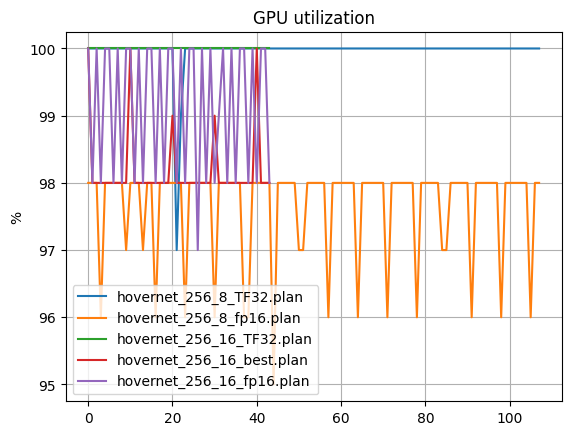

In [26]:
plt.title("GPU utilization")
plt.ylabel("%")
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        plt.plot(results_time_gpu_engine[path_plan][0][20:200],label = path_plan)
        plt.legend()
    
plt.grid()
plt.show()

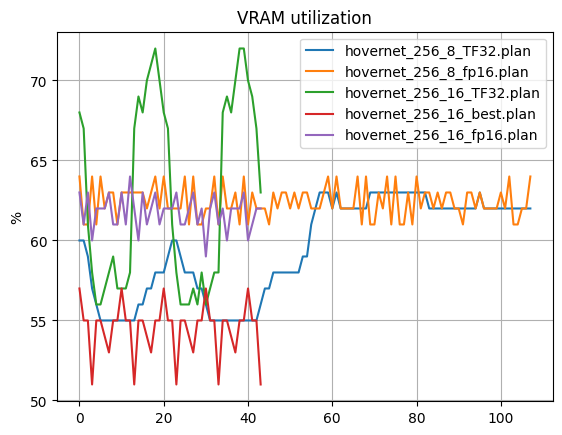

In [28]:
plt.title("VRAM utilization")
plt.ylabel("%")
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        plt.plot(results_time_gpu_engine[path_plan][1][20:200],label = path_plan)
        plt.legend()
    
plt.grid()
plt.show()

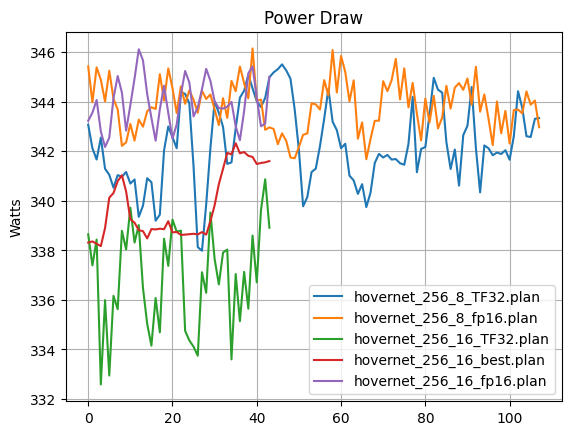

In [27]:
plt.title("Power Draw")
plt.ylabel("Watts")
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        plt.plot(results_time_gpu_engine[path_plan][2][20:200],label = path_plan)
        plt.legend()
    
plt.grid()
plt.show()

## Comparing the outputs

In [18]:
check_pic = brain_tiles[:16,:,:,:]
check_pic_cuda = check_pic.to('cuda')

In [19]:
outputs = {}

In [38]:
def visualize_channel(out,img_no = 0):
    fig , axs = plt.subplots(5,2,figsize=(12,15))
    k=0
    plt.axis('off')
    count = 0
    for i in range(5):
        for j in range(2):
            axs[i,j].xaxis.set_visible(False)
            axs[i,j].yaxis.set_visible(False)
            t = axs[i,j].imshow(outputs[name][img_no,k,:,:])
            plt.colorbar(t)
            axs[i,j].title.set_text( str(k) + " channel ")
            k+=1

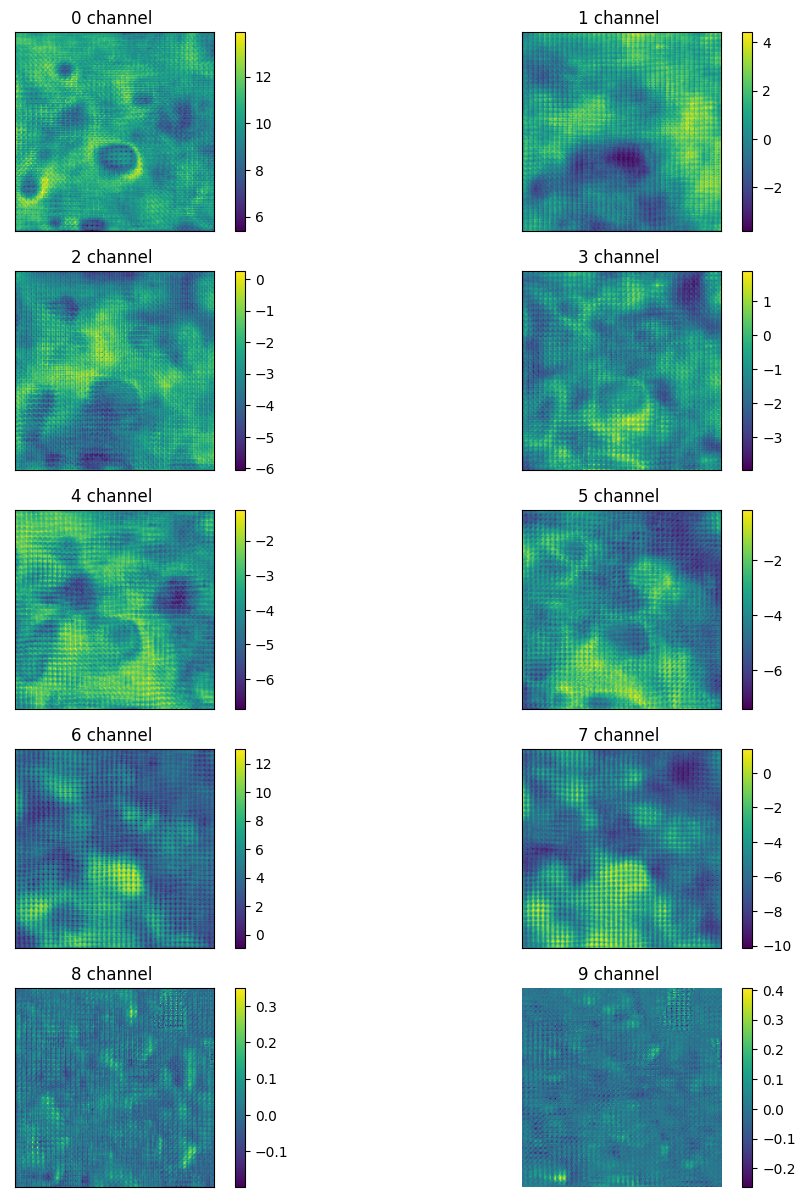

In [40]:
name = "hovernet_original"
check_pic = check_pic.to('cuda')
outputs[name] = hovernet.forward(check_pic[:16])
torch.cuda.empty_cache()
gc.collect()
outputs[name] = outputs[name].cpu()
outputs[name] = outputs[name].detach().numpy()
visualize_channel(outputs[name],15)

In [45]:
import tensorrt as trt
import pycuda.driver as cuda
import numpy as np
import pycuda.autoinit 

Batch_sizes = [8,16]
height = 164
width = 164
check_pic = check_pic.to('cpu')
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        engine = load_engine(path_plan)
        h_input_1, d_input_1, h_output, d_output, stream = inf.allocate_buffers(engine,1,trt.float32)
        with engine.create_execution_context() as context:
            for i in range(0,check_pic.shape[0],batch_size):
                inf.load_images_to_buffer(check_pic[i:i+batch_size,:,:,:], h_input_1)
                cuda.memcpy_htod_async(d_input_1, h_input_1, stream)
                context.execute_v2(bindings=[int(d_input_1), int(d_output)])
                cuda.memcpy_dtoh_async(h_output, d_output, stream)
                stream.synchronize()
                if(path_plan in outputs.keys()):
                    outputs[path_plan] = np.concatenate((outputs[path_plan],(h_output.reshape((batch_size,-1, height, width)))),axis=0)
                else:
                    outputs[path_plan] = h_output.reshape((batch_size,-1, height, width))
                

Reading engine from file hovernet_256_8_TF32.plan
Reading engine from file hovernet_256_8_fp16.plan
Reading engine from file hovernet_256_16_TF32.plan
Reading engine from file hovernet_256_16_best.plan
Reading engine from file hovernet_256_16_fp16.plan


In [46]:
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        print(path_plan,outputs[path_plan].shape)

hovernet_256_8_TF32.plan (16, 10, 164, 164)
hovernet_256_8_fp16.plan (16, 10, 164, 164)
hovernet_256_16_TF32.plan (16, 10, 164, 164)
hovernet_256_16_best.plan (16, 10, 164, 164)
hovernet_256_16_fp16.plan (16, 10, 164, 164)


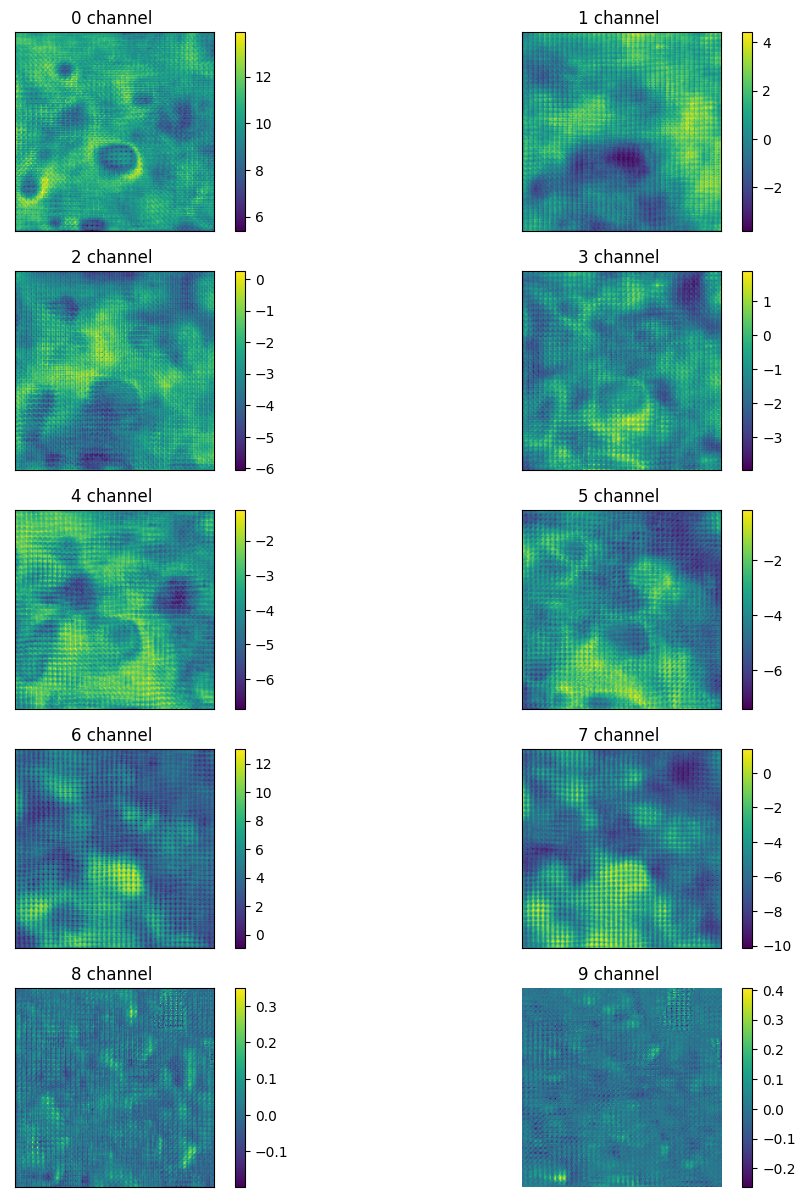

In [47]:
visualize_channel(outputs['hovernet_256_8_TF32.plan'],15)

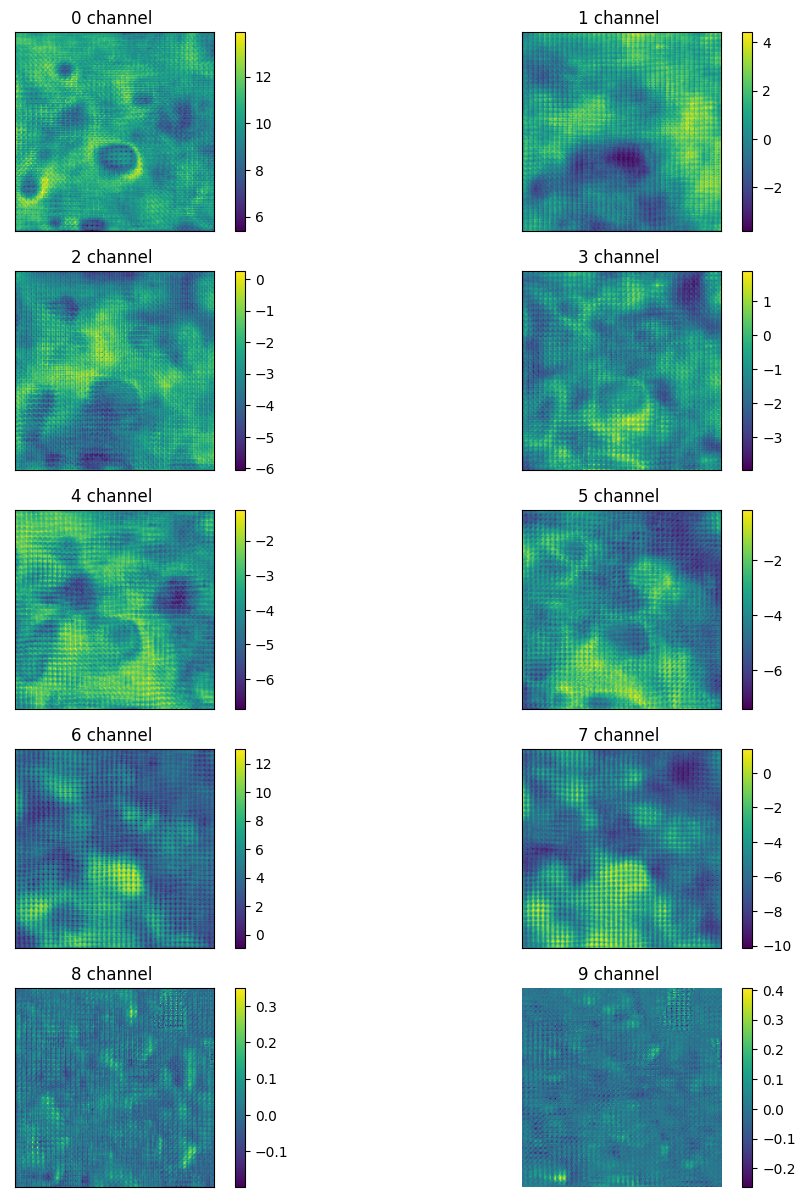

In [48]:
visualize_channel(outputs['hovernet_original'],15)

In [49]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
